In [218]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from ast import literal_eval
from embedding_creation import get_entities, Discipline
import json

sns.set_palette("Set2")
sns.set_theme("notebook")
sns.set_style("whitegrid")

In [219]:
op = pd.read_excel("skills_professions.xlsx")
op["skills"] = op.skills.apply(literal_eval)

vac_items = pd.read_excel("items_from_vacancies.xlsx")

vac_items.reset_index().rename(columns={"index": "id"}, inplace=True)
vac_items["lowercase"] = vac_items.name.str.lower()

In [220]:
df = pd.read_csv("plans_disciplines_vectorized.csv")

# данные по дисциплинам из БД
disc = pd.read_csv("disc_contents20230506_4.csv")
disc["comb_res"] = disc.comb_res.apply(literal_eval)

up = df[["up_id", "up_title", "course_id"]]
up = pd.merge(up, disc, left_on="course_id", right_on="id")

with open("up_isu_20230407.json") as f:
    js = json.load(f)

for up_isu in js.keys():
    for i in range(len(js[up_isu])):
        js[up_isu][i]["disciplines_blocks"] = json.loads(js[up_isu][i]["disciplines_blocks"])

df = pd.json_normalize(pd.DataFrame.from_dict(js)["up_isu"])
df = df[df["disciplines_blocks.block_name"] == "Блок 1. Модули (дисциплины)"]

explode_discipline_modules = df.explode("disciplines_blocks.discipline_modules")
explode_discipline_modules_norm = pd.json_normalize(explode_discipline_modules["disciplines_blocks.discipline_modules"])

attach_discipline_modules = pd.concat([explode_discipline_modules.reset_index(),
                                       explode_discipline_modules_norm.reset_index()], axis=1)
discipline_modules = attach_discipline_modules[["id", "direction_code", "edu_program_id", "edu_program_name",
                                                       "training_period", "selection_year", "module_id ", "module_name", "disciplines"]]

disciplines_explode = discipline_modules.explode("disciplines")
discipline_norm = pd.json_normalize(disciplines_explode["disciplines"])

disciplines = pd.concat([disciplines_explode.reset_index(), discipline_norm.reset_index()], axis=1)
edu_plans = disciplines[["id", "direction_code", "edu_program_id", "edu_program_name", "training_period",
                           "selection_year", "is_optional", "module_id ", "module_name", "plan_order", "dis_id", "disc_id", "discipline_name", "ze"]]

edu_plans["ze"] = edu_plans.ze.apply(lambda row: sum(filter(None, [elem["points"] for elem in row])))


df = pd.read_csv("plans_disciplines_vectorized.csv")

up = df[["up_id", "up_title", "course_id", "year", "qualification", "discipline_code"]]
up = pd.merge(up, disc, left_on="course_id", right_on="id")

valid_plans = edu_plans[["disc_id", "module_id ", "is_optional", "ze"]]
up = pd.merge(up, valid_plans, left_on="discipline_code_x", right_on="disc_id")

up.sample(3)

<ipython-input-220-8744895035e7>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edu_plans["ze"] = edu_plans.ze.apply(lambda row: sum(filter(None, [elem["points"] for elem in row])))


,up_id,up_title,course_id,year,qualification_x,discipline_code_x,Unnamed: 0,id,discipline_code_y,title,...,extracted_entities_n,combines_res,combined_res,res_n,comb_res,comb_res_n,disc_id,module_id,is_optional,ze
740176,7125,Нейротехнологии и программирование,14586,2021,bachelor,9410,3342,14586,9410,Лаборатория академического письма / Academic W...,...,5.0,"['Study Objective VS Research Statement', 'Spe...","['Study Objective VS Research Statement', 'Spe...",8,"[Study Objective VS Research Statement, Specif...",8,9410,4402,True,2
1443914,7253,Прикладная оптика / Applied Optics,20461,2022,master,21032,6408,20461,21032,Введение в МО (инструменты) и Методы ПИИ / Int...,...,9.0,"['Text processing', 'Speech Synthesis and Reco...","['Text processing', 'Speech Synthesis and Reco...",10,"[Text processing, Speech Synthesis and Recogni...",15,21032,12682,False,3
1728661,7198,Информационная безопасность / Information secu...,20464,2022,master,21043,6411,20464,21043,Креативные технологии / Creative Technologies,...,2.0,"['Креативные технологии', 'Design thinking', '...","['Креативные технологии', 'Design thinking', '...",10,"[Сценарии развития проектов, Сценарии развития...",18,21043,4765,True,3


In [221]:
up = up.drop_duplicates(subset=["up_id", "course_id"])
up.rename(columns={"qualification_x": "qualification"}, inplace=True)

up.qualification.value_counts()

bachelor      15692
master        13145
specialist      377
Name: qualification, dtype: int64

# Формирование списков навыков по ОП

In [222]:
def unnest(data):
    return [x for nested_list in data for x in nested_list]

def get_skills(data, coef_a=0, coef_b=0, above=False, below=False):
    if above:
        return [item[0] for item in data.items() if item[1] >= coef_a]
    elif below:
        return [item[0] for item in data.items() if item[1] <= coef_b]
    else:
        return [item[0] for item in data.items() if coef_b < item[1] < coef_a]

In [223]:
columns = ["op", "qualification", "key", "additional", "noise", "total"]
op_skills = pd.DataFrame(columns=columns)

op_groups = op.groupby(["op", "qualification"])
for gr in op_groups:
    df = gr[1].drop_duplicates(subset=["vac_id"])
    skills = unnest(df.skills.tolist())
    uniq_skills = Counter(skills)

    key_n = round(df.shape[0]*0.1)
    noise_n = round(df.shape[0]*0.01)

    key_skills = get_skills(uniq_skills, coef_a=key_n, above=True)
    noise_skills = get_skills(uniq_skills, coef_b=noise_n, below=True)
    add_skills = get_skills(uniq_skills, coef_a=key_n, coef_b=noise_n)
    
    op_skills = pd.concat([op_skills, 
                           pd.DataFrame([[df.iloc[0]["op"], df.iloc[0]["qualification"], 
                                          key_skills, add_skills, noise_skills, list(uniq_skills.keys())]], 
                                          columns=columns)])

In [224]:
op_skills

,op,qualification,key,additional,noise,total
0,"АВТОМАТИЗАЦИЯ И УПРАВЛЕНИЕ, AUTOMATION & CONTROL",master,"[Автоматизация технологических процессов, Auto...","[Английский язык, TCP/IP, C/C++, C++, Git, Lin...","[Fluent English, MAXIMO, Flow Measurements/Lev...","[Fluent English, Английский язык, MAXIMO, Flow..."
0,БЕЗОПАСНОСТЬ СИСТЕМ ИСКУССТВЕННОГО ИНТЕЛЛЕКТА,master,"[SQL, Бизнес-анализ, Разработка технических за...","[UML, REST, Моделирование бизнес процессов, Ag...","[IDEF, SOAP, GUI, XML, Системный подход, Систе...","[UML, IDEF, REST, SOAP, GUI, XML, SQL, Моделир..."
0,БИЗНЕС-ИНФОРМАТИКА,bachelor,"[Работа с большим объемом информации, Бизнес-а...","[Scrum, 1С: Предприятие, Техническая документа...","[Продвинутый пользователь ПК, Написание технич...","[Работа с большим объемом информации, Бизнес-а..."
0,БИОТЕХНОЛОГИЯ,bachelor,"[Контроль качества, Организаторские навыки]","[Активные продажи, Поиск и привлечение клиенто...","[Работа с ключевыми клиентами, Работа с локаль...","[Работа с ключевыми клиентами, Работа с локаль..."
0,БИОЭКОНОМИКА И УПРАВЛЕНИЕ РЕСУРСАМИ,master,[Химические методы анализа],"[Работа в команде, Организаторские навыки, Тел...","[PR, Анализ PR стратегии конкурентов, Коммуник...","[PR, Анализ PR стратегии конкурентов, Работа в..."
...,...,...,...,...,...,...
0,ЦИФРОВЫЕ ПРОДУКТЫ: СОЗДАНИЕ И УПРАВЛЕНИЕ,master,"[Разработка нового продукта, Управление команд...","[E-Commerce, Ассортиментная матрица, Управлени...","[Стратегический менеджмент, Продуктовая страте...","[E-Commerce, Стратегический менеджмент, Ассорт..."
0,ЭКОТЕХНОЛОГИИ И УСТОЙЧИВОЕ РАЗВИТИЕ,bachelor,"[Деловое общение, Поиск и привлечение клиентов...","[Навыки презентации, Планирование продаж, Упра...","[Аренда помещений, Договоры аренды, Региональн...","[Деловое общение, Аренда помещений, Договоры а..."
0,ЭЛЕКТРОИНЖЕНЕРИЯ,master,"[Чтение электросхем, Техническое обслуживание,...","[ГОСТ, Контроль качества, Пользователь ПК, Раб...","[испытатель, инженер, проведении испытаний, сх...","[испытатель, инженер, проведении испытаний, сх..."
0,ЭНЕРГОЭФФЕКТИВНЫЕ ИНЖЕНЕРНЫЕ СИСТЕМЫ И ТЕХНОЛО...,master,"[AutoCAD, Проектирование, Разработка проектной...","[Пользователь ПК, Проектирование зданий и соор...","[Компас, светопрозрачные конструкции, вентилир...","[AutoCAD, Компас, Пользователь ПК, Проектирова..."


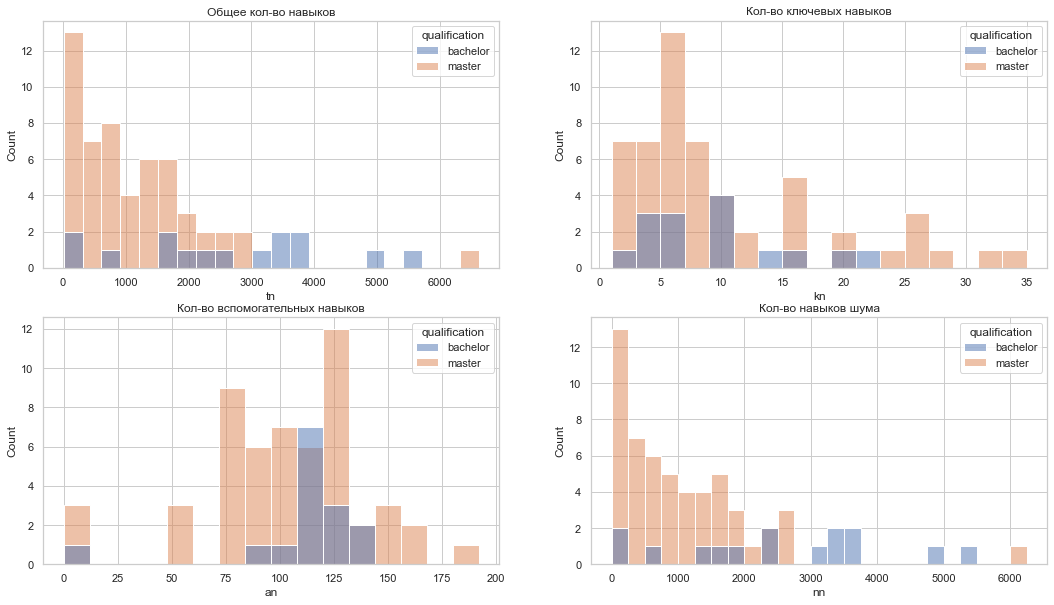

In [225]:
op_skills["kn"] = op_skills["key"].apply(len)
op_skills["an"] = op_skills.additional.apply(len)
op_skills["nn"] = op_skills.noise.apply(len)
op_skills["tn"] = op_skills.total.apply(len)

fig, axis = plt.subplots(2, 2, figsize=(18, 10))

axis[0][0].set_title(f"Общее кол-во навыков")
sns.histplot(ax=axis[0][0], data=op_skills.sort_values(by="qualification"), x="tn", binwidth=300, hue="qualification")

axis[0][1].set_title(f"Кол-во ключевых навыков")
sns.histplot(ax=axis[0][1], data=op_skills.sort_values(by="qualification"), x="kn", binwidth=2, hue="qualification")

axis[1][0].set_title(f"Кол-во вспомогательных навыков")
sns.histplot(ax=axis[1][0], data=op_skills.sort_values(by="qualification"), x="an", binwidth=12, hue="qualification")

axis[1][1].set_title(f"Кол-во навыков шума")
sns.histplot(ax=axis[1][1], data=op_skills.sort_values(by="qualification"), x="nn", binwidth=250, hue="qualification")

plt.show()

In [226]:
op_skills["title_lower"] = op_skills["op"].str.lower()
op_skills.sample()

,op,qualification,key,additional,noise,total,kn,an,nn,tn,title_lower
0,НЕЙРОТЕХНОЛОГИИ И ПРОГРАММИРОВАНИЕ,bachelor,"[SQL, 1С программирование, Git, Linux, Тестиро...","[С#, Java, C#, Базы данных, Обновление конфигу...","[WPF, WCF, Dapper, Автоматизация технологическ...","[SQL, С#, Java, WPF, WCF, Dapper, Автоматизаци...",6,108,2281,2395,нейротехнологии и программирование


# Извлечение навыков из дисциплин

In [227]:
import pymorphy2
import re

from tqdm import tqdm
from tqdm.auto import tqdm

tqdm.pandas()

analyzer = pymorphy2.MorphAnalyzer()

In [228]:
def unigramms_mapping(text, items):
    res = {analyzer.parse(re.sub(r"[^a-zA-Zа-яА-ЯёЁ\-\+\#]","", x))[0].normal_form for x in text.lower().split()}
    to_map = list(res & set(items.lowercase.tolist()))
    # print(to_map)
    entities = items.loc[items.lowercase.isin(to_map)]["name"].tolist()
    return entities

def extract_entities(text, items, unis, max_entities=50):
    res = get_entities(text, items, max_entities)+unigramms_mapping(text, unis)
    return list(set(res))

In [229]:
vac_items.dropna(inplace=True)
vac_items.reset_index(inplace=True)
vac_items.rename(columns={"index": "id"}, inplace=True)

In [230]:
vac_items.drop_duplicates(subset=["lowercase"], inplace=True)
vac_items.shape

(26839, 3)

In [231]:
vac_items["n_words"] = vac_items["lowercase"].apply(lambda x: len(x.split()))
vac_items

,id,name,lowercase,n_words
0,1,персональные данные,персональные данные,2
1,2,Ведение групп в социальных сетях,ведение групп в социальных сетях,5
2,3,Оформление текстилем,оформление текстилем,2
3,4,Разработка новых рецептур; соблюдение технолог...,разработка новых рецептур; соблюдение технолог...,6
4,5,ремонт автомобилей,ремонт автомобилей,2
...,...,...,...,...
30078,30080,Open vSwitch,open vswitch,2
30079,30081,UserGate,usergate,1
30080,30082,HiSilicon,hisilicon,1
30081,30083,Физик,физик,1


In [232]:
items24 = vac_items.query("n_words >= 2 & n_words <= 4")
items1 = vac_items.query("n_words == 1")

In [233]:
uniq_disc = up.drop_duplicates(subset=["raw_text"])
uniq_disc.shape

(5449, 28)

In [234]:
uniq_disc["prof_unis"] = uniq_disc["raw_text"].progress_apply(unigramms_mapping, items=items1)

100%|██████████| 5449/5449 [02:43<00:00, 33.31it/s]
<ipython-input-234-868cd57b2b38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_disc["prof_unis"] = uniq_disc["raw_text"].progress_apply(unigramms_mapping, items=items1)


In [235]:
uniq_disc["prof_24"] = uniq_disc["raw_text"].progress_apply(get_entities, items=items24, entities_to_match=50)

  0%|          | 20/5449 [00:36<2:45:18,  1.83s/it]


KeyboardInterrupt: 

In [ ]:
uniq_disc

,up_id,up_title,course_id,year,qualification,discipline_code_x,Unnamed: 0,id,discipline_code_y,title,...,combined_res,res_n,comb_res,comb_res_n,disc_id,module_id,is_optional,ze,prof_unis,prof_24
0,6940,Интеллектуальные системы в гуманитарной сфере,10258,2019,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"['Цветовая и тоновая коррекция', 'Типы мультим...",10,"[Цветовая и тоновая коррекция, Типы мультимеди...",16,2675,14,True,3,"[Видео, Связь, мультимедиа, с, звук, OCR, ПО, ...","[язык программирования Go, Язык программирования]"
169,6940,Интеллектуальные системы в гуманитарной сфере,2838,2019,bachelor,2790,104,2838,2790,Проектный менеджмент,...,"['Особенности оценки стартапа', 'Проектный мен...",10,"[Управление проектной командой, Управление про...",16,2790,14,True,3,"[разработка, Стратегия, SAM, развитие, с, Прое...","[Проектный менеджмент, Тестирование продуктов,..."
338,6924,Цифровые системы управления,10333,2019,bachelor,7130,1751,10333,7130,Инновационная экономика и технологическое пред...,...,"['Технологическое предпринимательство', 'Секто...",10,"[Технологическое предпринимательство, Секторы ...",14,7130,7101,False,3,"[Знание, разработка, DCF, маркетинг, NPV, экон...","[интеллектуальная собственность, минимизация р..."
23288,6927,Технологии защиты информации,7291,2019,bachelor,2259,1531,7291,2259,Компьютерная визуализация,...,"['Фотореалистичная визуализация', 'Типы источн...",10,"[Фотореалистичная визуализация, Типы источнико...",16,2259,7422,True,3,"[AutoDESK, Моделирование, Анимация, с, Проект,...","[3ds Max, Программное обеспечение, Autodesk 3d..."
25772,6924,Цифровые системы управления,4047,2019,bachelor,3528,518,4047,3528,Математика (базовый уровень),...,"['Обыкновенные дифференциальные уравнения', 'Ф...",10,"[Числовые ряды, Функция, Функциональные ряды, ...",30,3528,11,True,12,"[Знание, разработка, Моделирование, Инженер, И...","[дифференциальные уравнения, Алгоритмическое м..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942989,7462,Математические технологии системного анализа,23947,2023,master,31271,7890,23947,31271,Дискретное моделирование,...,"['Теория игр', 'Раскраска графа', 'Принцип мин...",10,"[Теория игр, Раскраска графа, Принцип минимакс...",10,31271,10176,False,3,"[химия, Знание, Моделирование, конструирование...","[Информационные статьи, Транспортный отдел, ре..."
1942990,7462,Математические технологии системного анализа,23949,2023,master,31275,7891,23949,31275,Управление в сложных системах,...,"['Теория автоматического управления', 'Информа...",10,"[Теория автоматического управления, Информацио...",11,31275,10176,False,3,"[Моделирование, Обучение, Преподавание, Управл...","[теории автоматического управления, Технологич..."
1942993,7462,Математические технологии системного анализа,23951,2023,master,31277,7892,23951,31277,Технологии теории игр,...,"['Теория игр', 'Вариационное исчисление.', 'Ос...",4,"[Теория игр, Вариационное исчисление., Основы ...",4,31277,10176,False,3,"[Моделирование, с, технология]",[]
1942994,7462,Математические технологии системного анализа,23952,2023,master,31279,7893,23952,31279,Статистический анализ систем,...,"['Статистические модели', 'Проверка статистиче...",8,"[Статистические модели, Проверка статистически...",8,31279,10176,False,3,"[Моделирование, Проверка, с, Анализ, Оценка, К...","[Статистический анализ, Анализ временных рядов..."


In [ ]:
uniq_disc["prof_skills"] = uniq_disc["prof_unis"]+uniq_disc["prof_24"]

<ipython-input-88-d6d3fcca7843>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_disc["prof_skills"] = uniq_disc["prof_unis"]+uniq_disc["prof_24"]


In [ ]:
up1 = pd.merge(up, uniq_disc[["raw_text", "prof_skills"]], left_on="raw_text", right_on="raw_text", how="left")
up1.shape

(29214, 29)

In [ ]:
up1.to_csv("up_and_prof_skills.csv", index=False)

In [ ]:
up1.columns

Index(['up_id', 'up_title', 'course_id', 'year', 'qualification',
       'discipline_code_x', 'Unnamed: 0', 'id', 'discipline_code_y', 'title',
       'qualification_y', 'description', 'work_status', 'section_topic',
       'raw_text', 'author_entities', 'author_entities_n',
       'extracted_entities', 'extracted_entities_n', 'combines_res',
       'combined_res', 'res_n', 'comb_res', 'comb_res_n', 'disc_id',
       'module_id ', 'is_optional', 'ze', 'prof_skills', 'op_lower'],
      dtype='object')

In [ ]:
op_prof = pd.merge(up1, op_skills, left_on=["op_lower", "qualification"], right_on=["title_lower", "qualification"], how="left")
op_prof.dropna(subset=["title_lower"], inplace=True)

In [ ]:
op_prof.columns

Index(['up_id', 'up_title', 'course_id', 'year', 'qualification',
       'discipline_code_x', 'Unnamed: 0', 'id', 'discipline_code_y', 'title',
       'qualification_y', 'description', 'work_status', 'section_topic',
       'raw_text', 'author_entities', 'author_entities_n',
       'extracted_entities', 'extracted_entities_n', 'combines_res',
       'combined_res', 'res_n', 'comb_res', 'comb_res_n', 'disc_id',
       'module_id ', 'is_optional', 'ze', 'prof_skills', 'op_lower', 'op',
       'key', 'additional', 'noise', 'total', 'kn', 'an', 'nn', 'tn',
       'title_lower'],
      dtype='object')

In [ ]:
columns1 = ["op", "qualification", "year", "cov", "foc", "R", "R1"]
op_metric = pd.DataFrame(columns=columns1)

op_profs = op_prof.groupby(["up_id", "qualification"])
for group in op_profs:
    try:
        df = group[1]
        skills = unnest(df.prof_skills.tolist())
        key_skills = set(unnest(df["key"].tolist()))
        add_skills = set(unnest(df["additional"].tolist()))
        noise = set(unnest(df["noise"].tolist()))
        total = set(unnest(df["total"].tolist()))
        core = len(set(skills) & set(key_skills))/len(key_skills)
        additional = len(set(skills) & set(add_skills))/len(add_skills)
        cov = 0.8*core + 0.2*additional

        res = [bool(set(x)&(key_skills|add_skills)) for x in df.prof_skills.tolist()]
        res1 = [bool(set(x)&(total)) for x in df.prof_skills.tolist()]
        foc = sum(res)/len(res)
        foc1 = sum(res1)/len(res1)

        r = round((2*cov*foc)/(cov+foc),3)
        r1 = round((2*cov*foc1)/(cov+foc1),3)
        # print(r, r1)

        op_metric = pd.concat([op_metric, pd.DataFrame([[df.iloc[0]["up_title"], df.iloc[0]["qualification"],
                                                        df.iloc[0]["year"], round(cov,3), round(foc,3), r, r1]], columns=columns1)])
    except ZeroDivisionError:
        pass


In [ ]:
op_metric

,op,qualification,year,cov,foc,R,R1
0,Лазерные технологии,bachelor,2018,0.069,0.196,0.102,0.128
0,Компьютерные технологии в дизайне,bachelor,2018,0.303,0.726,0.428,0.460
0,Нейротехнологии и программирование,bachelor,2018,0.437,0.667,0.528,0.603
0,Мобильные и сетевые технологии,bachelor,2018,0.574,0.400,0.471,0.720
0,Бизнес-информатика,bachelor,2020,0.651,0.496,0.563,0.789
...,...,...,...,...,...,...,...
0,Лазерные технологии,master,2021,0.424,0.149,0.220,0.378
0,Информационные технологии в теплофизике,master,2020,0.042,0.188,0.068,0.068
0,Информационные технологии в теплофизике,master,2021,0.042,0.150,0.065,0.065
0,Инженерия цифровых систем,master,2023,0.170,0.375,0.234,0.234


ValueError: min() arg is an empty sequence

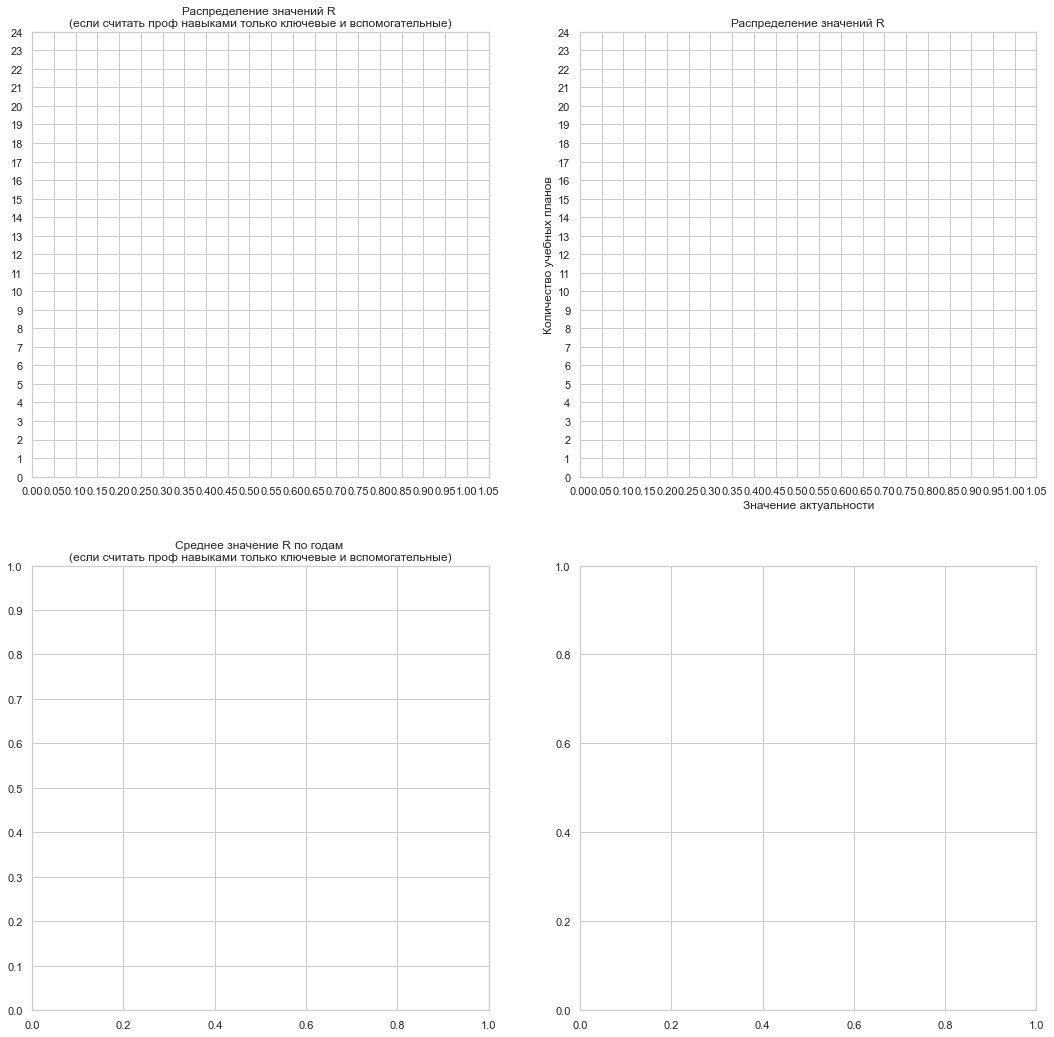

In [ ]:
metric_mean = op_metric.groupby(["year", "qualification"])["R"].mean().reset_index()
metric_mean1 = op_metric.groupby(["year", "qualification"])["R1"].mean().reset_index()

fig, axis = plt.subplots(2, 2, figsize=(18, 18))

axis[0][0].set_title(f"Распределение значений R \n(если считать проф навыками только ключевые и вспомогательные)")
axis[0][0].set_yticks(np.arange(0,25,1))
axis[0][0].set_xticks(np.arange(0,1.1,0.05))
sns.histplot(ax=axis[0][0], data=op_metric.query("year != 2023").sort_values(by="qualification"), x="R", binwidth=0.05, hue="qualification")

axis[0][1].set_title(f"Распределение значений R")
axis[0][1].set_yticks(np.arange(0,25,1))
axis[0][1].set_xticks(np.arange(0,1.1,0.05))
sns.histplot(ax=axis[0][1], data=op_metric.query("year != 2023").sort_values(by="qualification"), 
             x="R1", binwidth=0.05, hue="qualification")
axis[0][1].set_ylabel("Количество учебных планов")
axis[0][1].set_xlabel("Значение актуальности")

axis[1][0].set_title(f"Среднее значение R по годам \n(если считать проф навыками только ключевые и вспомогательные)")
axis[1][0].set_yticks(np.arange(0,1.1,0.1))
axis[1][0].set_ylim(0,1)
sns.barplot(ax=axis[1][0], data=metric_mean.query("year != 2023").sort_values(by="qualification"), x="year", y="R", hue="qualification")

axis[1][1].set_title(f"Среднее значение R по годам")
axis[1][1].set_yticks(np.arange(0,1.1,0.1))
axis[1][1].set_ylim(0,1)
sns.barplot(ax=axis[1][1], data=metric_mean1.query("year != 2023").sort_values(by="qualification"), x="year", y="R1", hue="qualification")
axis[1][1].set_ylabel("Значение актуальности")
axis[1][1].set_xlabel("Год набора УП")

plt.show()

Интересно, что на актуальные на данный момент навыки, требуемые вакансиями, больше всего похожи планы 2020 года бакалавриата, а магистратуры – 2022.

In [ ]:
op_metric.query("R1 > 0.6")

,op,qualification,year,cov,foc,R,R1
0,Нейротехнологии и программирование,bachelor,2018,0.437,0.667,0.528,0.603
0,Мобильные и сетевые технологии,bachelor,2018,0.574,0.400,0.471,0.720
0,Бизнес-информатика,bachelor,2020,0.651,0.496,0.563,0.789
0,Бизнес-информатика,bachelor,2019,0.651,0.523,0.580,0.789
0,Биотехнология,bachelor,2019,0.440,0.407,0.423,0.608
0,Мобильные и сетевые технологии,bachelor,2019,0.581,0.406,0.478,0.732
0,Нейротехнологии и программирование,bachelor,2019,0.437,0.563,0.492,0.601
0,Программирование в инфокоммуникационных системах,bachelor,2019,0.577,0.515,0.544,0.645
0,Программирование в инфокоммуникационных системах,bachelor,2021,0.582,0.528,0.554,0.639
0,Биотехнология,bachelor,2020,0.440,0.388,0.412,0.608


In [ ]:
op_metric.query("R1 < 0.2")

,op,qualification,year,cov,foc,R,R1
0,Лазерные технологии,bachelor,2018,0.069,0.196,0.102,0.128
0,Мобильные и облачные технологии,master,2021,0.014,0.143,0.025,0.027
0,Электроинженерия,master,2021,0.016,0.186,0.029,0.031
0,Программирование и интернет-технологии,master,2021,0.019,0.250,0.036,0.038
0,Инфохимия,bachelor,2021,0.170,0.179,0.174,0.174
0,Биоэкономика и управление ресурсами,master,2020,0.018,0.229,0.034,0.036
0,Электроинженерия,master,2020,0.013,0.125,0.024,0.026
0,Программирование и интернет-технологии,master,2020,0.016,0.241,0.030,0.031
0,Системное и прикладное программное обеспечение,master,2020,0.027,0.326,0.051,0.053
0,Лазерные технологии,master,2020,0.019,0.132,0.033,0.035


Очень низкие значения можно объяснить тем, что сами профессии указаны очень размыто. Например, для "Информационных технологий в теплофизике" профессии такие: инженер-исследователь, разработчик инновационных принципов функционирования высокотехнологичных устройств, проектировщик в области энергоэффективности зданий

In [ ]:
df_mas.loc[df_mas["op"] == "ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ"].dropna()

,Unnamed: 0,vac_id,vac_title,op,job,skills,qualification
228952,228952,94515594,Ведущий инженер-проектировщик ОВ,ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['AutoCAD', 'Разработка проектной документации...",master
228953,228953,89527935,Инженер-проектировщик отопления и вентилляции,ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,[],master
228954,228954,97505141,Инженер-проектировщик систем электроснабжения,ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['Проектная документация', 'Проектирование', '...",master
228955,228955,96012166,"Инженер-проектировщик систем отопления, вентил...",ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['Проектная документация', 'Проектирование', '...",master
228956,228956,96539721,Главный специалист ОВиК в Проектный институт,ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,[],master
228957,228957,96539973,Ведущий инженер-проекировщик ОВиК в Проектный ...,ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,[],master
228958,228958,92693403,Технолог/инженер-проектировщик (ТХ),ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['Проектная документация', 'Экологическая безо...",master
228959,228959,93204956,"Технолог/инженер-проектировщик, ТХ",ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['Проектная документация', 'Экологическая безо...",master
228960,228960,95023339,Инженер-проектировщик (город Пятигорск),ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,['Гражданское и строительное проектирование: З...,master
228961,228961,97200100,Инженер - проектировщик ОВ ( I категория),ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ В ТЕПЛОФИЗИКЕ,проектировщик в области энергоэффективности зд...,"['Revit', 'Проектная деятельность', 'AutoCAD',...",master


## Эксперименты с актуальностью

### случайные сущности

In [ ]:
columns1 = ["op", "qualification", "year", "cov", "foc", "R", "R1"]
op_metric1 = pd.DataFrame(columns=columns1)

op_profs = op_prof.groupby(["up_id", "qualification"])
for group in op_profs:
    try:
        df = group[1]
        skills = unnest(df.rand_res.tolist())
        key_skills = set(unnest(df["key"].tolist()))
        add_skills = set(unnest(df["additional"].tolist()))
        noise = set(unnest(df["noise"].tolist()))
        total = set(unnest(df["total"].tolist()))
        core = len(set(skills) & set(key_skills))/len(key_skills)
        additional = len(set(skills) & set(add_skills))/len(add_skills)
        cov = 0.8*core + 0.2*additional

        res = [bool(set(x)&(key_skills|add_skills)) for x in df.prof_skills.tolist()]
        res1 = [bool(set(x)&(total)) for x in df.prof_skills.tolist()]
        foc = sum(res)/len(res)
        foc1 = sum(res1)/len(res1)

        r = round((2*cov*foc)/(cov+foc),3)
        r1 = round((2*cov*foc1)/(cov+foc1),3)
        # print(r, r1)

        op_metric1 = pd.concat([op_metric1, pd.DataFrame([[df.iloc[0]["up_title"], df.iloc[0]["qualification"],
                                                        df.iloc[0]["year"], round(cov,3), round(foc,3), r, r1]], columns=columns1)])
    except ZeroDivisionError:
        pass


op_metric1["Квалификация"] = op_metric1["qualification"].apply(lambda x: "Магистратура" if x == "master" else "Бакалавриат")

In [ ]:
from random import sample, shuffle

In [ ]:
list(sample(vac_items["name"].tolist(), 5))

['Разработка обуви',
 'Трекинг задач',
 'проектирирование электрических схем',
 'Знание ассортимента древесно-кустарниковых растений',
 'CAPsMAN']

In [ ]:
op_prof["pn"] = op_prof["prof_skills"].apply(len)

In [ ]:
op_prof["pn"].describe()

count    7340.000000
mean       21.319346
std        10.494670
min         2.000000
25%        14.000000
50%        20.000000
75%        28.000000
max        74.000000
Name: pn, dtype: float64

In [ ]:
op_prof["rand_res"] = op_prof["pn"].apply(lambda x: list(sample(vac_items["name"].tolist(), x)))
op_prof

,up_id,up_title,course_id,year,qualification,discipline_code_x,Unnamed: 0,id,discipline_code_y,title,...,additional,noise,total,kn,an,nn,tn,title_lower,rand_res,pn
1,6941,Программирование в инфокоммуникационных системах,10258,2019,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"[SRE, Hadoop, Kafka, MySQL, Nginx, CI/CD, ELK,...","[Airflow, Ni-Fi, Elasticsearch, ЦФТ, kotlin, I...","[SRE, Hadoop, Airflow, Ni-Fi, Kubernetes, Kafk...",9.0,111.0,613.0,733,программирование в инфокоммуникационных системах,"[Восстановление данных, Химик, Двигатели внутр...",18
2,6918,Мобильные и сетевые технологии,10258,2019,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"[iOS, Английский язык, C++, C#, Linux, TypeScr...","[Qt, MS Visual Studio, React-Native, Мобильная...","[iOS, Английский язык, Android, C++, C#, Qt, M...",9.0,109.0,2354.0,2472,мобильные и сетевые технологии,"[Выкладка товара, NX, Продакшен, закупки проду...",18
4,7035,Мобильные и сетевые технологии,10258,2020,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"[iOS, Английский язык, C++, C#, Linux, TypeScr...","[Qt, MS Visual Studio, React-Native, Мобильная...","[iOS, Английский язык, Android, C++, C#, Qt, M...",9.0,109.0,2354.0,2472,мобильные и сетевые технологии,"[задачи оптимизации, Работа с тизерными сетями...",18
8,6989,Программирование в инфокоммуникационных системах,10258,2020,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"[SRE, Hadoop, Kafka, MySQL, Nginx, CI/CD, ELK,...","[Airflow, Ni-Fi, Elasticsearch, ЦФТ, kotlin, I...","[SRE, Hadoop, Airflow, Ni-Fi, Kubernetes, Kafk...",9.0,111.0,613.0,733,программирование в инфокоммуникационных системах,"[SAP HCM-PY, FICT, DNS, Режим многозадачности,...",18
9,6943,Программирование в инфокоммуникационных системах,10258,2021,bachelor,2675,1728,10258,2675,Основы обработки мультимедийных данных,...,"[SRE, Hadoop, Kafka, MySQL, Nginx, CI/CD, ELK,...","[Airflow, Ni-Fi, Elasticsearch, ЦФТ, kotlin, I...","[SRE, Hadoop, Airflow, Ni-Fi, Kubernetes, Kafk...",9.0,111.0,613.0,733,программирование в инфокоммуникационных системах,"[отгрузка оборудования, ИК, Перегородки, RHEL ...",18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29209,6909,Бизнес-информатика,24548,2020,bachelor,29972,8159,24548,29972,Базы данных,...,"[Scrum, 1С: Предприятие, Техническая документа...","[Продвинутый пользователь ПК, Написание технич...","[Работа с большим объемом информации, Бизнес-а...",4.0,117.0,3560.0,3681,бизнес-информатика,"[Расчеты на прочность, EDR/XDR, Аналитик бизне...",22
29210,6909,Бизнес-информатика,24547,2020,bachelor,29971,8158,24547,29971,Инновационные технологии бизнеса,...,"[Scrum, 1С: Предприятие, Техническая документа...","[Продвинутый пользователь ПК, Написание технич...","[Работа с большим объемом информации, Бизнес-а...",4.0,117.0,3560.0,3681,бизнес-информатика,"[объекты культурного наследия, способность раб...",35
29211,7462,Математические технологии системного анализа,23951,2023,master,31277,7892,23951,31277,Технологии теории игр,...,"[C++, Математический анализ, MATLAB, Математич...","[Вычислительная математика, Линейная алгебра, ...","[C++, Математический анализ, Вычислительная ма...",9.0,96.0,1801.0,1906,математические технологии системного анализа,[осуществляет монтаж и настройку электронной т...,3
29212,7462,Математические технологии системного анализа,23952,2023,master,31279,7893,23952,31279,Статистический анализ систем,...,"[C++, Математический анализ, MATLAB, Математич...","[Вычислительная математика, Линейная алгебра, ...","[C++, Математический анализ, Вычислительная ма...",9.0,96.0,1801.0,1906,математические технологии системного анализа,"[DOMObject, ARM CORTEX, стереокамеры, Разработ...",11


In [ ]:
op_metric1

,op,qualification,year,cov,foc,R,R1,Квалификация
0,Лазерные технологии,bachelor,2018,0.168,0.196,0.181,0.286,Бакалавриат
0,Компьютерные технологии в дизайне,bachelor,2018,0.098,0.726,0.172,0.177,Бакалавриат
0,Нейротехнологии и программирование,bachelor,2018,0.009,0.667,0.018,0.018,Бакалавриат
0,Мобильные и сетевые технологии,bachelor,2018,0.013,0.400,0.025,0.025,Бакалавриат
0,Бизнес-информатика,bachelor,2020,0.021,0.496,0.039,0.040,Бакалавриат
...,...,...,...,...,...,...,...,...
0,Лазерные технологии,master,2021,0.013,0.149,0.024,0.026,Магистратура
0,Информационные технологии в теплофизике,master,2020,0.038,0.188,0.064,0.064,Магистратура
0,Информационные технологии в теплофизике,master,2021,0.073,0.150,0.098,0.098,Магистратура
0,Инженерия цифровых систем,master,2023,0.000,0.375,0.000,0.000,Магистратура


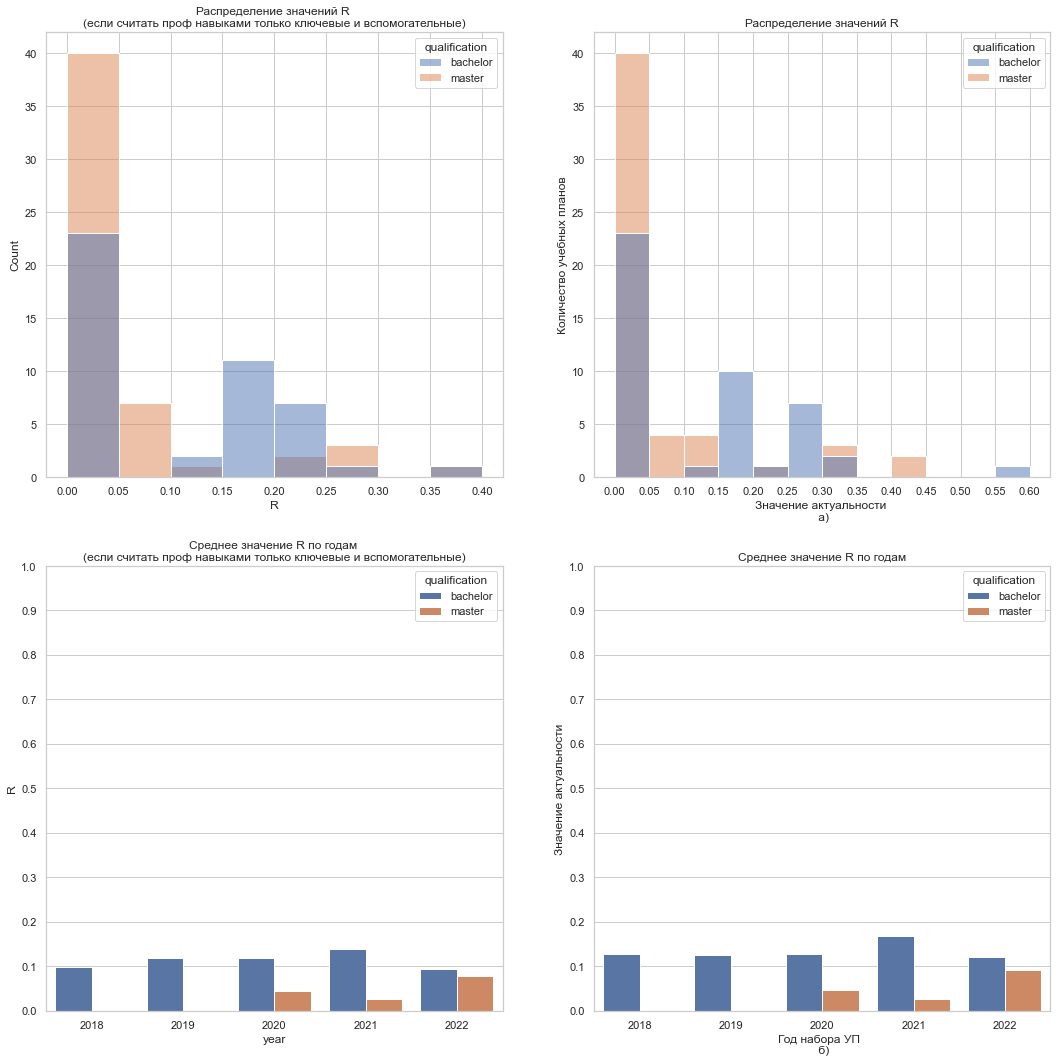

In [ ]:
metric_mean = op_metric1.groupby(["year", "qualification"])["R"].mean().reset_index()
metric_mean1 = op_metric1.groupby(["year", "qualification"])["R1"].mean().reset_index()

fig, axis = plt.subplots(2, 2, figsize=(18, 18))

axis[0][0].set_title(f"Распределение значений R \n(если считать проф навыками только ключевые и вспомогательные)")
axis[0][0].set_yticks(np.arange(0,50,5))
axis[0][0].set_xticks(np.arange(0,1.1,0.05))
sns.histplot(ax=axis[0][0], data=op_metric1.query("year != 2023").sort_values(by="qualification"), x="R", binwidth=0.05, hue="qualification")

axis[0][1].set_title(f"Распределение значений R")
axis[0][1].set_yticks(np.arange(0,50,5))
axis[0][1].set_xticks(np.arange(0,1.1,0.05))
sns.histplot(ax=axis[0][1], data=op_metric1.query("year != 2023").sort_values(by="qualification"), 
             x="R1", binwidth=0.05, hue="qualification")
axis[0][1].set_ylabel("Количество учебных планов")
axis[0][1].set_xlabel("Значение актуальности \n a)")

axis[1][0].set_title(f"Среднее значение R по годам \n(если считать проф навыками только ключевые и вспомогательные)")
axis[1][0].set_yticks(np.arange(0,1.1,0.1))
axis[1][0].set_ylim(0,1)
sns.barplot(ax=axis[1][0], data=metric_mean.query("year != 2023").sort_values(by="qualification"), x="year", y="R", hue="qualification")

axis[1][1].set_title(f"Среднее значение R по годам")
axis[1][1].set_yticks(np.arange(0,1.1,0.1))
axis[1][1].set_ylim(0,1)
sns.barplot(ax=axis[1][1], data=metric_mean1.query("year != 2023").sort_values(by="qualification"), x="year", y="R1", hue="qualification")
axis[1][1].set_ylabel("Значение актуальности")
axis[1][1].set_xlabel("Год набора УП  \n б)")

plt.show()